# Plot SnowModel output from AWS Zarr datasets
4/22/2020. https://github.com/emiliom

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import s3fs
import xarray as xr

from snowmodelzarrfs import connect_fs, get_zarrstore

In [2]:
xr.__version__, s3fs.__version__

('0.15.1', '0.4.0')

Warning: The statement `FS = s3fs.S3FileSystem(session=aws_session)` below is failing when using `s3fs` version 0.4.2 (current version on conda-forge, 4/4/2020) and `boto3` 1.12.35 and 1.12.36. But it does work when using `s3fs` 0.4.0 and `boto3` 1.12.27.

## Initiate a Dask Gateway cluster if available
`dask_gateway` only expected to be available on https://pangeo.io JupyterHub or a similar cloud environment.

In [3]:
try:
    from dask.distributed import Client, progress
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=4, maximum=20);

    client = Client(cluster)
    client
    
    print("Using Dask gateway cluster.")
except ImportError:
    print("Dask gateway cluster not available.")

Dask gateway cluster not available.


## Open AWS S3 file system

In [4]:
# Options: localfs, localminio_s3, aws_s3, anon_aws_s3
FS_type, bucket = "anon_aws_s3", "snowmodel"
aws_profile_name = 'cso'

In [5]:
FS = connect_fs(FS_type, aws_profile_name=aws_profile_name)

## Time series plot at two points

Read from `snowmodel/swe_run_a-ts.zarr`, a zarr dataset optimized for cell time-series queries such as a time-series plot at one location (pixel) over the whole temporal range or statistics calculated on the data from one location.

In [6]:
zarrds = "swe_run_a-ts.zarr"

In [7]:
zarrstore_ts = get_zarrstore(FS, FS_type, bucket, zarrds)

In [8]:
zdsts = xr.open_zarr(
    store=zarrstore_ts, 
    consolidated=True
)

In [9]:
zdsts

,Array,Chunk
Bytes,24.98 GB,41.40 MB
Shape,"(1825, 2476, 1382)","(460, 150, 150)"
Count,681 Tasks,680 Chunks
Type,float32,numpy.ndarray


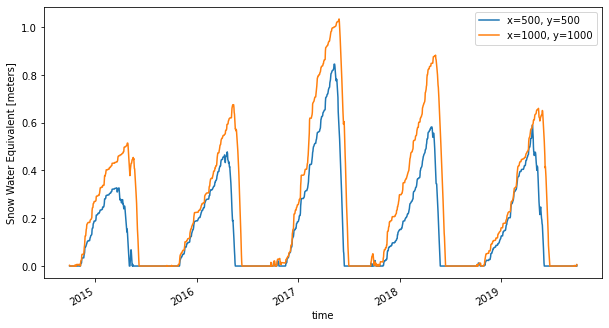

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 5))
zdsts.swe.isel(x=500, y=500).plot(ax=ax, label="x=500, y=500")
zdsts.swe.isel(x=1000, y=1000).plot(ax=ax, label="x=1000, y=1000")
plt.legend(loc="upper right");
plt.title(None);
# A legend is not generated automatically. 
# The auto title is not quite right; it's specific to one plot

## Maps of the same day across years

Read from `snowmodel/swe_run_a-geo.zarr`, a zarr dataset optimized for whole-spatial-domain queries such as a map figure of a specific day (time step) or statistics calculated on the data from one time step.

**NOTE:** the `xr.open_zarr` statement below is pretty slow. We'll need to look into it.

In [11]:
zarrgeo = "swe_run_a-geo.zarr"

In [12]:
zarrstore_geo = get_zarrstore(FS, FS_type, bucket, zarrgeo)

In [13]:
zdsgeo = xr.open_zarr(
    store=zarrstore_geo, 
    consolidated=True
)

In [14]:
zdsgeo

,Array,Chunk
Bytes,24.98 GB,54.75 MB
Shape,"(1825, 2476, 1382)","(4, 2476, 1382)"
Count,458 Tasks,457 Chunks
Type,float32,numpy.ndarray


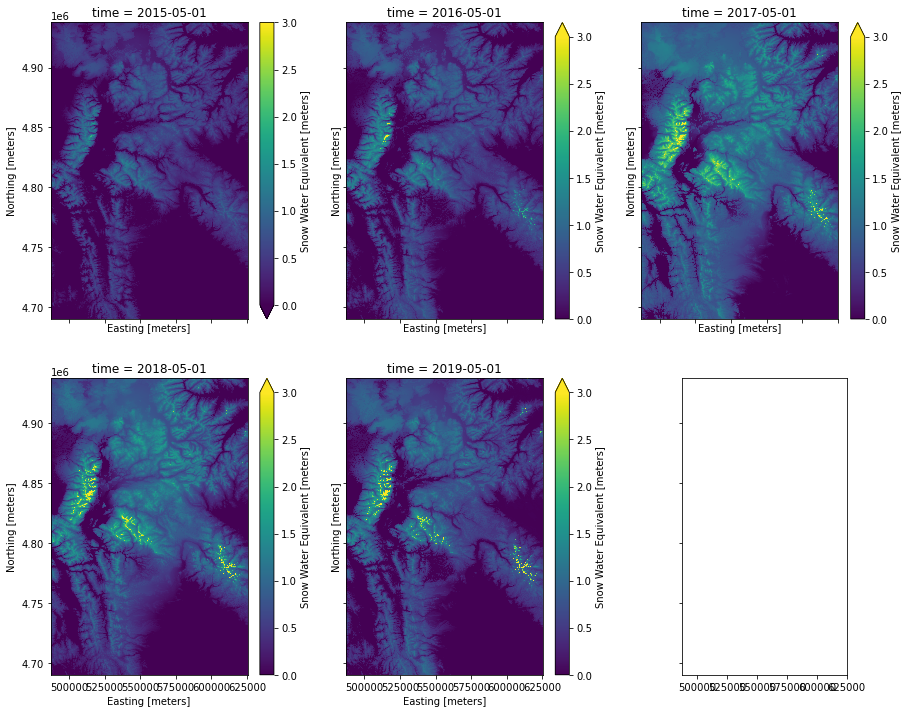

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 12))

# add_colorbar=False
vrange = {'vmin':0, 'vmax':3}
zdsgeo.swe.sel(time='2015-05-01').plot(ax=ax[0,0], **vrange)
zdsgeo.swe.sel(time='2016-05-01').plot(ax=ax[0,1], **vrange)
zdsgeo.swe.sel(time='2017-05-01').plot(ax=ax[0,2], **vrange)
zdsgeo.swe.sel(time='2018-05-01').plot(ax=ax[1,0], **vrange)
zdsgeo.swe.sel(time='2019-05-01').plot(ax=ax[1,1], **vrange)

plt.axis('scaled');